In [1]:
%matplotlib inline                

# Example 3:  Reading an NCEP BUFR data set
NCEP BUFR (Binary Universal Form for the Representation of meteorological data) can be read two ways:

- **Fortran code with BUFRLIB**
    
- **py-ncepbufr, which is basically Python wrappers around BUFRLIB**

In this example we'll use py-ncepbufr to read a snapshot of the Argo data tank from WCOSS, show how to navigate the BUFR structure, and how to extract and plot a profile.

The py-ncepbufr library and installation instructions can be found at

https://github.com/JCSDA/py-ncepbufr


- Once again we begin by importing the required libraries.

In [2]:
import matplotlib.pyplot as plt    # graphics library
import numpy as np
import ncepbufr                    # python wrappers around BUFRLIB
import cartopy.crs as ccrs         # cartographic coord reference system
import cartopy.feature as cfeature # features (land, borders, coastlines)

- For the purposes of this demo I've made a local copy of the Argo data tank on WCOSS 
located at

**/dcom/us007003/201808/b031/xx005** 
    
- Begin by opening the file

In [3]:
bufr = ncepbufr.open('xx005')

- Movement and data access within the BUFR file is through these methods:
  - `bufr.advance()`
  - `bufr.load_subset()`
  - `bufr.read_subset()`
  - `bufr.rewind()`
  - `bufr.close()`
- There is a lot more functionality to ncepbufr, such as searching on multiple mnenomics, printing or saving the BUFR table included in the file, printing or saving the inventory and subsets, setting and using checkpoints in the file.  See the ncepbufr help for more details.

- ***Important Note:*** Unlike pygrib, netCDF4-python or xarray, ncepbufr is unforgiving of mistakes.  A BUFRLIB error will result in an *immediate* exit from the Python interpreter.  

In [4]:
# move down to first message - a return code of 0 indicates success
bufr.advance()  

0

In [5]:
# load the message subset -- a return code of 0 indicates success
bufr.load_subset() 

0

- You can print the subset and determine the parameter names.  BUFR dumps can be ***very*** verbose, so I'll just copy in the header and the first subset replication from a `bufr.dump_subset()` command.

- I've highlighted in red the parameters I want to plot.

<pre style="font-size: x-small">
MESSAGE TYPE NC031005  

004001  YEAR                      2018.0  YEAR                          YEAR                                            
004002  MNTH                         8.0  MONTH                         MONTH                                           
004003  DAYS                         1.0  DAY                           DAY                                             
004004  HOUR                         0.0  HOUR                          HOUR                                            
004005  MINU                        16.0  MINUTE                        MINUTE                                          
035195  SEQNUM                       317  ( 4)CCITT IA5                 CHANNEL SEQUENCE NUMBER                         
035021  BUHD                      IOPX01  ( 6)CCITT IA5                 BULLETIN BEING MONITORED (TTAAii)               
035023  BORG                        KWBC  ( 4)CCITT IA5                 BULLETIN BEING MONITORED (CCCC)                 
035022  BULTIM                    010029  ( 6)CCITT IA5                 BULLETIN BEING MONITORED (YYGGgg)               
035194  BBB                      MISSING  ( 6)CCITT IA5                 BULLETIN BEING MONITORED (BBB)                  
008202  RCTS                         0.0  CODE TABLE                    RECEIPT TIME SIGNIFICANCE                       
004200  RCYR                      2018.0  YEAR                          YEAR   - TIME OF RECEIPT                        
004201  RCMO                         8.0  MONTH                         MONTH  - TIME OF RECEIPT                        
004202  RCDY                         1.0  DAY                           DAY    - TIME OF RECEIPT                        
004203  RCHR                         0.0  HOUR                          HOUR   - TIME OF RECEIPT                        
004204  RCMI                        31.0  MINUTE                        MINUTE - TIME OF RECEIPT                        
033215  CORN                         0.0  CODE TABLE                    CORRECTED REPORT INDICATOR                      
001087  WMOP                   6903327.0  NUMERIC                       WMO marine observing platform extended identifie
001085  OPMM                        S2-X  (20)CCITT IA5                 Observing platform manufacturer's model         
001086  OPMS        10151                             ( 32)CCITT IA5                Observing platform manufacturer's serial number 
002036  BUYTS                        2.0  CODE TABLE                    Buoy type                                       
002148  DCLS                         8.0  CODE TABLE                    Data collection and/or location system          
002149  BUYT                        14.0  CODE TABLE                    Type of data buoy                               
022055  FCYN                        28.0  NUMERIC                       Float cycle number                              
022056  DIPR                         0.0  CODE TABLE                    Direction of profile                            
022067  IWTEMP                     846.0  CODE TABLE                    INSTRUMENT TYPE FOR WATER TEMPERATURE PROFILE ME
005001  CLATH                   59.34223  DEGREES                       LATITUDE (HIGH ACCURACY)                        
006001  CLONH                   -9.45180  DEGREES                       LONGITUDE (HIGH ACCURACY)                       
008080  QFQF                        20.0  CODE TABLE                    Qualifier for GTSPP quality flag                
033050  GGQF                         1.0  CODE TABLE                    Global GTSPP quality flag                       
           (GLPFDATA)   636 REPLICATIONS
    ++++++  GLPFDATA  REPLICATION #     1  ++++++
<span style="color: red">007065  WPRES                    10000.0  PA                            Water pressure</span>
008080  QFQF                        10.0  CODE TABLE                    Qualifier for GTSPP quality flag                
033050  GGQF                         1.0  CODE TABLE                    Global GTSPP quality flag                       
<span style="color: red">022045  SSTH                     285.683  K                             Sea/water temperature</span>
008080  QFQF                        11.0  CODE TABLE                    Qualifier for GTSPP quality flag                
033050  GGQF                         1.0  CODE TABLE                    Global GTSPP quality flag
<span style="color: red">022064  SALNH                     35.164  PART PER THOUSAND             Salinity</span>
008080  QFQF                        12.0  CODE TABLE                    Qualifier for GTSPP quality flag                
033050  GGQF                         1.0  CODE TABLE                    Global GTSPP quality flag                       
</pre>


- Now we can load the data for plotting


In [6]:
temp = bufr.read_subset('SSTH').squeeze()-273.15  # convert from Kelvin to Celsius
sal = bufr.read_subset('SALNH').squeeze()
depth = bufr.read_subset('WPRES').squeeze()/10000. # convert from Pa to depth in meters
# observation location, date, and receipt time
lon = bufr.read_subset('CLONH')[0][0]
lat = bufr.read_subset('CLATH')[0][0]
date = bufr.msg_date
receipt = bufr.receipt_time
bufr.close()


- Set up the plotting figure.  But this time, just for fun, let's put both the temperature and salinity profiles on the same axes.  This trick uses both the top and bottom axis for different parameters.

- As these are depth profiles, we need twin x-axes and a shared y-axis for the depth.


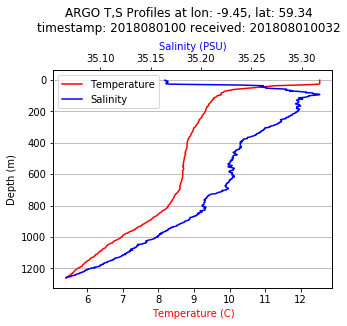

In [7]:
fig = plt.figure(figsize = (5,4))
ax1 = plt.axes()
ax1.plot(temp, depth,'r-')
ax1.grid(axis = 'y')
ax1.invert_yaxis()       # flip the y-axis for ocean depths
ax2 = ax1.twiny()          # here's the second x-axis definition
ax2.plot(np.nan, 'r-', label = 'Temperature')
ax2.plot(sal, depth, 'b-', label = 'Salinity')
ax2.legend()
ax1.set_xlabel('Temperature (C)', color = 'red')
ax1.set_ylabel('Depth (m)')
ax2.set_xlabel('Salinity (PSU)', color = 'blue')
ttl='ARGO T,S Profiles at lon:{:6.2f}, lat:{:6.2f}\ntimestamp: {} received: {}\n'.format(lon,lat,date,receipt)
fig.suptitle(ttl,x = 0.5,y = 1.1,fontsize = 'large');

## Any questions?
